# Accelerated SGD

> We want to iterate quickly, so we need our training to run quickly as well

Adapted from:

- [https://youtu.be/vGsc_NbU7xc?si=xn-rYgIuG1j4r9ll&t=5348](https://youtu.be/vGsc_NbU7xc?si=xn-rYgIuG1j4r9ll&t=5348)

In [1]:
# |export
from functools import partial

import fastcore.all as fc
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torchmetrics.classification import MulticlassAccuracy

from slowai.activations import (
    set_seed,
)
from slowai.convs import to_device
from slowai.datasets import get_grid, show_image
from slowai.initializations import (
    CNNWithGeneralReLUAndBatchNorm,
    GeneralReLU,
    init_leaky_weights,
)
from slowai.learner import (
    DeviceCB,
    MetricsCB,
    MomentumCB,
    ProgressCB,
    TrainLearner,
    fashion_mnist,
)

In [2]:
set_seed(42)
plt.style.use("ggplot")

This was the best model from the previous. We're going to make this better!

MulticlassAccuracy,loss,epoch,train
0.817,0.506,0,train
0.847,0.426,0,eval
0.868,0.359,1,train
0.863,0.381,1,eval
0.882,0.321,2,train
0.867,0.368,2,eval


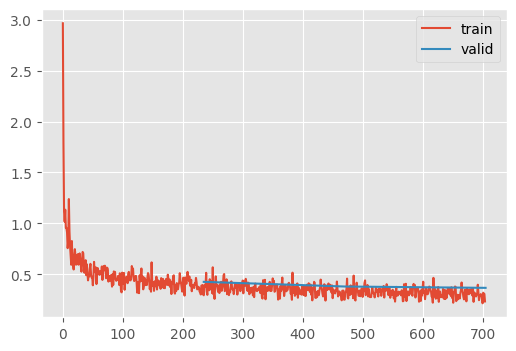

MulticlassAccuracy,loss,epoch,train
0.899,0.277,0,train
0.880,0.328,0,eval
0.902,0.270,1,train
0.881,0.325,1,eval


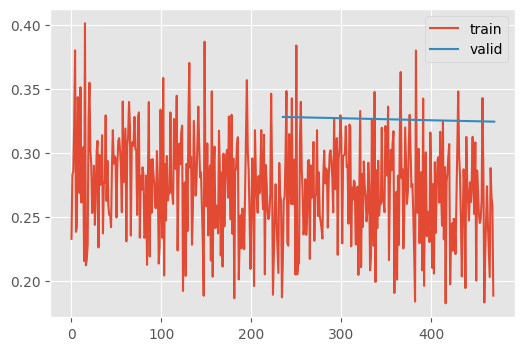

In [3]:
leak = 0.1
model = CNNWithGeneralReLUAndBatchNorm(gr=partial(GeneralReLU, leak=leak))
model.apply(partial(init_leaky_weights, leak=leak))
cbs = [
    MetricsCB(MulticlassAccuracy(num_classes=10)),
    DeviceCB(),
    ProgressCB(plot=True),
    MomentumCB(),
]
dls = fashion_mnist(256)
TrainLearner(
    model,
    dls,
    F.cross_entropy,
    lr=0.2,
    cbs=cbs,
).fit(3)
TrainLearner(
    model,
    dls,
    F.cross_entropy,
    lr=0.05,
    cbs=cbs,
).fit(2)

## Implementing Stochastic Gradient Descent

Let's start to implement our own optimizer class.

Remember, the learner class interfaces with the optimizer solely through the constructor and the `step` function. 

```python
@with_cbs("batch")
def _one_batch(self):
    self.predict()
    self.callback("after_predict")
    self.get_loss()
    self.callback("after_loss")
    if self.training:
        self.backward()
        self.callback("after_backward")
        self.step() # 👈
        self.callback("after_step")
        self.zero_grad()
# ...

def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
    with tempfile.TemporaryDirectory() as tdir:
        self.dls.tdir = tdir
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs:
            self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None:
                lr = self.lr
            if self.opt_func:
                self.opt = self.opt_func(self.model.parameters(), lr) # 👈
            self._fit(train, valid)
        finally:
            for cb in cbs:
                self.cbs.remove(cb)
```

Therefore, we only need to implement those two interfaces.

Here it is, without modification.

In [4]:
class SGD:
    def __init__(self, params, lr, wd=0):
        params = list(params)
        fc.store_attr()
        self.i = 0

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i += 1

    def opt_step(self, p):
        p -= p.grad * self.lr

    def reg_step(self, p):
        if self.wd != 0:
            p *= 1 - self.lr * self.wd

    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()

## Weight Decay Regularization

Suppose we want to apply a loss on the weights themselves as a regularization? (Where $k$ is the weight decay parameter.)
$$
L = loss(y) + loss(w) = loss(y) + \sum_{i=1}^d k (w_{i})^2
$$

We need the derivative to compute the backwards gradient.

$$
\frac{\partial L}{\partial w} =  \frac{\partial loss(y)}{\partial w} +  \sum_{i=1}^d 2k (w_{i})
$$

Let's assume that `torch` has already computed $\frac{\partial loss(y)}{\partial w}$. Then, we could do:

```python
weight.grad += wd * weight
```

Of course, we are about that perform `opt_step` anyways, which subtracts `lr * weight.grad` from the parameters. Therefore,

```python
p *= 1 - self.lr * self.wd
```

is equivalent.

## Momentum

We already have `MomentumCB`, but its hacky. This really deserves to be in the optimizer class.

Let's get a sense of the parameters of momentum.

In [5]:
xs = torch.linspace(-4, 4, 100)
ys = 1 - (xs / 3) ** 2 + torch.randn(100) * 0.1

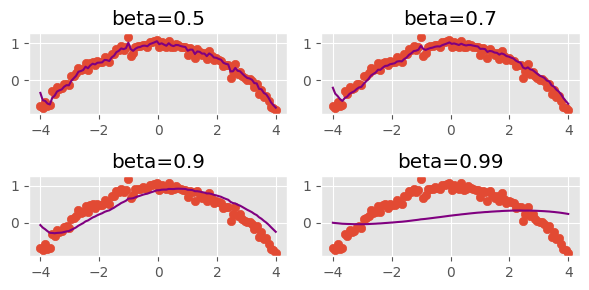

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(6, 3))
betas = [0.5, 0.7, 0.9, 0.99]
for beta, ax in zip(betas, axs.flatten()):
    ax.scatter(xs, ys)
    avg, res = 0, []
    for yi in ys:
        avg = beta * avg + (1 - beta) * yi
        res.append(avg)
    ax.plot(xs, np.array(res), color="purple")
    ax.set_title(f"beta={beta}")
fig.tight_layout()

This demonstrates how momentum can smooth out the loss surface.

In [7]:
class MomentumSGD(SGD):
    def __init__(self, params, lr, wd=0, mom=0.9):
        super().__init__(params, lr, wd)
        self.mom = mom

    def opt_step(self, p):
        grad_avg = getattr(p, "grad_avg", torch.zeros_like(p.grad))

        # This is slight more sophisticated than the MomentumCB because
        # it wasn't apropriately weighting the existing gradients
        p.grad_avg = grad_avg * self.mom + p.grad * (1 - self.mom)

        p -= p.grad_avg * self.lr

Let's try this on FashionMNIST, returning to the larger batch size and learning rate.

MulticlassAccuracy,loss,epoch,train
0.796,0.568,0,train
0.816,0.516,0,eval
0.861,0.382,1,train
0.851,0.407,1,eval
0.884,0.316,2,train
0.864,0.388,2,eval


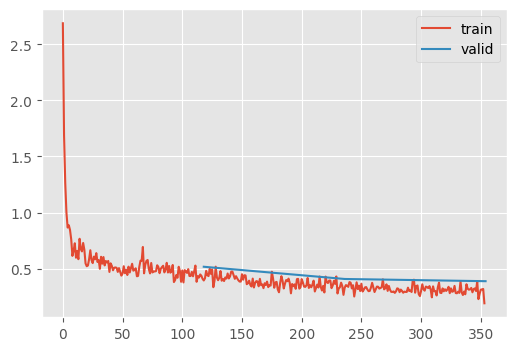

In [8]:
model = CNNWithGeneralReLUAndBatchNorm(gr=partial(GeneralReLU, leak=leak))
model.apply(partial(init_leaky_weights, leak=leak))
cbs = [MetricsCB(MulticlassAccuracy(num_classes=10)), DeviceCB(), ProgressCB(plot=True)]
TrainLearner(
    model,
    fashion_mnist(512),
    F.cross_entropy,
    lr=1.25,  # 👈 learning rate is WAY up
    cbs=cbs,
    opt_func=MomentumSGD,
).fit(3)

MulticlassAccuracy,loss,epoch,train
0.901,0.268,0,train
0.885,0.319,0,eval


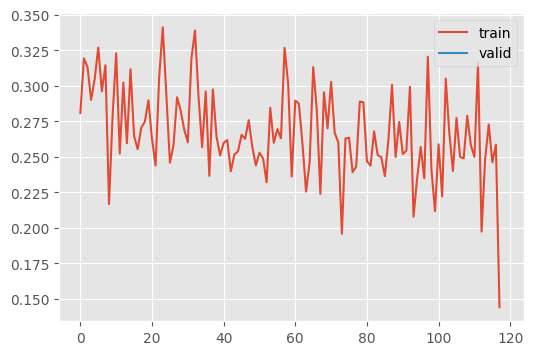

In [9]:
TrainLearner(
    model,
    fashion_mnist(512),
    F.cross_entropy,
    lr=0.25,  # 👈 learning rate is WAY up
    cbs=cbs,
    opt_func=MomentumSGD,
).fit(1)


Jeremy goes on a tangent here and discusses batch sizes. In theory, larger batch sizes represent a more accurate reprentation of the loss surface. But they also imply that there are fewer update steps, which is bad! Supposedly, Yan LeCunn (originally) thought that the ideal batch size is one, whereas the norm these days is to have a batch size of millions.

## RMSProp

Momentum can be "aggressive" for some finicky architectures. `RMSProp` is a historically interesting architecture that can be used instead. This was an optimization algorithm debuted in a Coursera by Hinton. It was never published.

The algorithm interpolates between the **square of the gradient** and the momentum. Large squared gradients imply large variances. This allows the network to take larger steps in directions where gradients are consistently small, and smaller steps in directions where gradients are fluctuating or large. In other words, it gives each parameter a chance to shine 🌟

In [10]:
class RMSProp(SGD):
    def __init__(self, params, lr, wd=0.0, sqr_mom=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.sqr_mom, self.eps = sqr_mom, eps

    def opt_step(self, p):
        # Note that Jeremy initializes the squared average as that of the current
        # gradient, instead of 0. Otherwise, p.sqr_avg.sqrt() + self.eps is a
        # very large value and the initial learning rate is very high
        sqr_avg = getattr(p, "sqr_avg", p.grad**2)
        #                                    vvvvvvvvv
        p.sqr_avg = sqr_avg * self.sqr_mom + p.grad**2 * (1 - self.sqr_mom)
        p -= self.lr * p.grad / (p.sqr_avg.sqrt() + self.eps)

How does this do on FashionMNIST?

MulticlassAccuracy,loss,epoch,train
0.790,0.612,0,train
0.816,0.516,0,eval
0.859,0.378,1,train
0.828,0.505,1,eval
0.871,0.344,2,train
0.835,0.485,2,eval


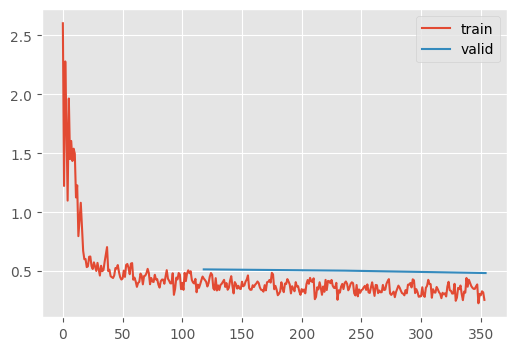

In [11]:
model = CNNWithGeneralReLUAndBatchNorm(gr=partial(GeneralReLU, leak=leak))
model.apply(partial(init_leaky_weights, leak=leak))
cbs = [MetricsCB(MulticlassAccuracy(num_classes=10)), DeviceCB(), ProgressCB(plot=True)]
TrainLearner(
    model,
    fashion_mnist(512),
    F.cross_entropy,
    lr=1e-2,
    cbs=cbs,
    opt_func=RMSProp,
).fit(3)

## Adam

RMSProp and momentum are usually seen together in the Adam optimizer.

Keep in mind that $\beta$ terms `beta1` and `beta2` are just momentum and squared momentum! 

In [12]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0.0, beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1, self.beta2, self.eps = beta1, beta2, eps

    def opt_step(self, p):
        if not hasattr(p, "avg"):
            p.avg = torch.zeros_like(p.grad.data)
        if not hasattr(p, "sqr_avg"):
            p.sqr_avg = torch.zeros_like(p.grad.data)
        p.avg = self.beta1 * p.avg + (1 - self.beta1) * p.grad

        # For the first minibatch, the momentum is 0, so the gradient
        # should be quite small. However, we know this is the case and
        # we can adjust for it because we know how far from 0 it should
        # be -- i.e., $(beta_1)^2$. Therefore, we can divide by 1 minus
        # this term to increase the average. Note that as i increases,
        # the unbiased avg approaches the original avg
        unbias_avg = p.avg / (1 - (self.beta1 ** (self.i + 1)))

        p.sqr_avg = self.beta2 * p.sqr_avg + (1 - self.beta2) * (p.grad**2)

        # Same idea as above
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2 ** (self.i + 1)))

        # Finally, we perform the learning rate modulation for momentum and
        # RMSProp
        p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()

MulticlassAccuracy,loss,epoch,train
0.828,0.476,0,train
0.860,0.396,0,eval
0.877,0.332,1,train
0.865,0.378,1,eval
0.890,0.297,2,train
0.875,0.358,2,eval


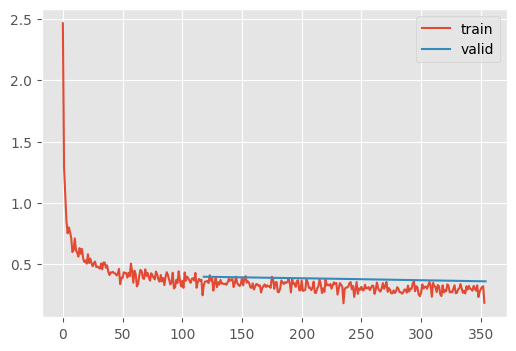

In [13]:
model = CNNWithGeneralReLUAndBatchNorm(gr=partial(GeneralReLU, leak=leak))
model.apply(partial(init_leaky_weights, leak=leak))
cbs = [MetricsCB(MulticlassAccuracy(num_classes=10)), DeviceCB(), ProgressCB(plot=True)]
TrainLearner(
    model,
    fashion_mnist(512),
    F.cross_entropy,
    lr=1e-2,
    cbs=cbs,
    opt_func=Adam,
).fit(3)

MulticlassAccuracy,loss,epoch,train
0.911,0.242,0,train
0.891,0.305,0,eval
0.916,0.229,1,train
0.893,0.301,1,eval
0.918,0.222,2,train
0.894,0.299,2,eval


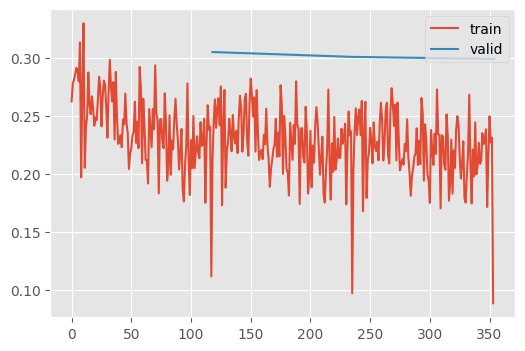

In [14]:
TrainLearner(
    model,
    fashion_mnist(512),
    F.cross_entropy,
    lr=1e-3,
    cbs=cbs,
    opt_func=Adam,
).fit(3)

In [15]:
#| hide
import nbdev

nbdev.nbdev_export()

/home/jeremy/micromamba/envs/slowai/lib/python3.11/site-packages/nbdev/export.py:73: UserWarning: Notebook '/home/jeremy/Desktop/SlowAI/nbs/11_accelerated_sgd.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
